# Set up environment

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Test if GPU is available
# Note that CUDA below 12.1 can have bugs
import torch
print(torch.cuda.is_available())
# print(torch.cuda.get_device_name(0))
print(torch.version.cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True
12.1


In [3]:
#%% import libraries
import os
from collections import defaultdict
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import copy
import numpy as np
import numpy.random
from numpy.fft import fft as fft
from numpy.fft import ifft as ifft
import pickle
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
import scipy.stats
from scipy.stats import wilcoxon, chi2
import scipy.interpolate 
import scipy.signal
from scipy import linalg
from scipy.special import rel_entr
from tqdm import tqdm
import pandas as pd
import joblib
import logging

import statsmodels.api as sm
import statsmodels.genmod.generalized_linear_model as smm

import torch
from torch.autograd import Variable
from torch.nn import functional as F
import torch.nn as nn
import torch.optim as optim

In [4]:
# import my code
import utility_functions as utils
import GLM
from DataLoader import Allen_dataset, Allen_dataloader_multi_session, Simple_dataloader_from_spikes
from model_trainer import Trainer

utils.set_seed(0)

/home/qix/anaconda3/envs/allen/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Generate synthetic data

In [223]:
from VAETransformer_FCGPFA import get_K
### Generate data
torch.manual_seed(1)
np.random.seed(1)

MAX_FIRING_RATE = 10
gt_neuron_params = {'baseline_fr':0.05, 'ntrial':5000, 'narea':2, 'nneuron_area':50, 
                    'nt':250, 'npadding':50}
gt_latent_params = {'sigma2':0.5, 'nlatent':2, 'offset':0.0, 'L':150}
coupling_filter_params = {'peaks_max':5, 'num':3, 'nonlinear':0.5}
nfactor_baseline = gt_latent_params['nlatent']
connections = [{'send':0, 'receive':1, 
                'strength': np.array([[1.0,0.0],[0.0,0.0],[0,0.0]]),
                'nneuron_involved': 10}]

ntrial = gt_neuron_params['ntrial']
nneuron = gt_neuron_params['narea']*gt_neuron_params['nneuron_area']
nneuron_area = gt_neuron_params['nneuron_area']
narea = gt_neuron_params['narea']
basis_coupling = GLM.make_pillow_basis(**coupling_filter_params)
max_histories, nbasis = basis_coupling.shape
nt = gt_neuron_params['nt'] + gt_neuron_params['npadding']
nfactor_coupling_tot = sum([conn['strength'].shape[1] for conn in connections])

baseline_mat = np.ones((nt, nneuron, ntrial))*np.log(gt_neuron_params['baseline_fr'])
spikes = np.zeros((nt, nneuron, ntrial))
log_firing_rate_rcd = np.zeros((nt, nneuron, ntrial))
factor_coupling = np.zeros((nt, nfactor_coupling_tot, ntrial))
factor_baseline_rcd = np.zeros((nt, nfactor_baseline, ntrial, narea))

# Prepare loading_mat_baseline
loading_mat_baseline_list = [np.zeros((nneuron_area, nfactor_baseline)) for _ in range(narea)]
for jarea in range(narea):
    loading_mat_baseline_list[jarea] = (
        np.random.uniform(low=-0.9, high=1.0, size=(nneuron_area, nfactor_baseline))
    )

# Prepare baseline_mat
for jarea in range(narea):
    K_gt = get_K(nt=nt, L=gt_latent_params['L'], sigma2=gt_latent_params['sigma2'])
    factor_baseline = np.random.multivariate_normal(
        np.zeros(nt), K_gt, (ntrial, nfactor_baseline)
    ).transpose(2, 1, 0) # nt x nlatent x ntrial
    baseline_mat[:, jarea*nneuron_area:(jarea+1)*nneuron_area, :] += (
        np.einsum('nf, tfm -> tnm', loading_mat_baseline_list[jarea], factor_baseline)
    )
    factor_baseline_rcd[:, :, :, jarea] = factor_baseline

# Prepare coupling_mat
readin_mat_coupling = np.zeros((nneuron, nfactor_coupling_tot))
coupling_mat = np.zeros((max_histories, nneuron, nfactor_coupling_tot))
loading_mat_coupling = np.zeros((nneuron, nfactor_coupling_tot))
nfactor_coupling_counter = 0
for i, connection in enumerate(connections):
    nneuron_involved = connection['nneuron_involved']
    nfactor_coupling = connection['strength'].shape[1]
    temp = np.random.uniform(low=0.8, high=1.2, size=(nneuron_involved, nfactor_coupling))
    temp /= np.linalg.norm(temp, axis=0)[np.newaxis, :]
    readin_mat_coupling[
        connection['send']*nneuron_area:connection['send']*nneuron_area+nneuron_involved,
        nfactor_coupling_counter:nfactor_coupling_counter+nfactor_coupling
    ] = temp
    coupling_mat[
        :, 
        connection['send']*nneuron_area:connection['send']*nneuron_area+nneuron_involved,
        nfactor_coupling_counter:nfactor_coupling_counter+nfactor_coupling
    ] = (basis_coupling @ connection['strength'])[::-1, np.newaxis, :]
    coupling_mat *= readin_mat_coupling[np.newaxis, :, :]
    temp = np.random.uniform(low=0.8, high=1.2, size=(nneuron_involved, nfactor_coupling))
    temp /= np.linalg.norm(temp, axis=0)[np.newaxis, :]
    loading_mat_coupling[
        connection['receive']*nneuron_area:connection['receive']*nneuron_area+nneuron_involved,
        nfactor_coupling_counter:nfactor_coupling_counter+nfactor_coupling
    ] = temp
    nfactor_coupling_counter += nfactor_coupling

# Generate spikes
for itrial in tqdm(range(ntrial)):
    spikes_single_trial = np.zeros((nt, nneuron, 1))
    log_firing_rate = copy.copy(baseline_mat[:,:,itrial:itrial+1])
    spikes_single_trial[0,:,0] = np.random.poisson(np.exp(log_firing_rate[0,:, 0]))

    for t in range(1, nt):
        nhistories = min(t, max_histories)
        factor_coupling_single = (coupling_mat[-nhistories:, :, :] \
                * spikes_single_trial[(t-nhistories):(t), :, :]).sum(axis=(0, 1))
        factor_coupling[t,:,itrial] = factor_coupling_single
        log_firing_rate[t,:,0] += (loading_mat_coupling @ factor_coupling_single[:, np.newaxis]).squeeze()
        log_firing_rate[t,:,0] = np.minimum(log_firing_rate[t,:,0], MAX_FIRING_RATE)
        spikes_single_trial[t,:,0] = np.random.poisson(np.exp(log_firing_rate[t,:,0]))
        # spikes_single_trial[t,:,0] = np.exp(log_firing_rate[t,:,0])

    log_firing_rate = log_firing_rate.squeeze()
    spikes_single_trial = spikes_single_trial.squeeze()
    spikes[:, :, itrial] = spikes_single_trial
    log_firing_rate_rcd[:, :, itrial] = log_firing_rate


spikes_area = [spikes[:,iarea*nneuron_area:(iarea+1)*nneuron_area,:] for iarea in range(narea)]

100%|██████████| 5000/5000 [00:41<00:00, 121.71it/s]


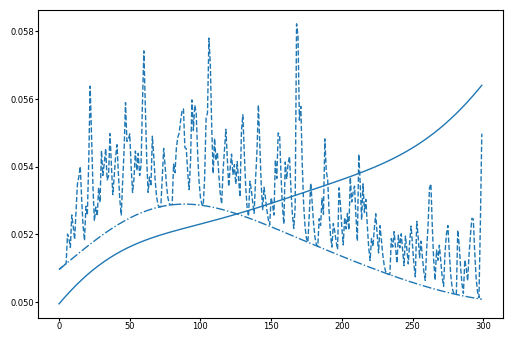

In [224]:
plt.figure(figsize=(6,4))
trials_to_plot = 1

for trial in range(trials_to_plot):  # Plot first 20 trials
    # Get mean across neurons for this trial
    pop1_mean = np.exp(log_firing_rate_rcd[:,:gt_neuron_params["nneuron_area"],trial].mean(axis=1))
    pop2_mean = np.exp(log_firing_rate_rcd[:,gt_neuron_params["nneuron_area"]:,trial].mean(axis=1))
    pop1_baseline = np.exp(baseline_mat[:,gt_neuron_params["nneuron_area"]:,trial].mean(axis=1))
    line, = plt.plot(pop1_mean)
    plt.plot(pop2_mean, "--", color=line.get_color())
    plt.plot(pop1_baseline, "-.", color=line.get_color())


Text(0.5, 1.0, 'Spike raster for neuron 52')

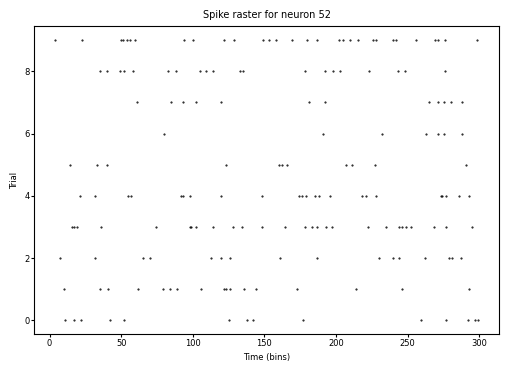

In [225]:
# Plot raster for one example neuron
neuron_idx = gt_neuron_params['nneuron_area']+2  # Choose first neuron
plt.figure(figsize=(6,4))
for trial in range(10):  # Plot first 200 trials
    spike_times = np.where(spikes[:,neuron_idx,trial])[0]
    plt.plot(spike_times, trial*np.ones_like(spike_times), '.', markersize=1, color='black')
plt.xlabel('Time (bins)')
plt.ylabel('Trial')
plt.title(f'Spike raster for neuron {neuron_idx}')


In [226]:
nneuron = spikes.shape[1]//2

synthetic_dataloader = Simple_dataloader_from_spikes(
    [spikes[:,:nneuron,:], spikes[:,nneuron:,:]],
    npadding=50,
    train_ratio=0.7,
    val_ratio=0.1,
    batch_size=64,
    verbose=True
)

# Train a model

Current problems:
- Not stable! Run the code multiple times, the results are different. **Solved by temporal correlation penalty**
- The coupling effect is not capturing what it should capture. ** **

Things I want to try:
- see if the baseline looks good. **YES**
- I want to get a clear two modes in t-sne plot, since the ground truth is two modes. **YES**
- Play with hyperparameters, see what appect the results. **lr is still very important. Epoch is also important.**
- Try make coupling effect weaker by setting initial value to be around zero. I don't want to see the coupling effect being too strong. **can be done by frozing Transformer encoder**
- See how would overlapping penalty affect the results. overlapping_penalty=None: 0.2283
overlapping_penalty=1e0: 0.2289. **but overlapping penalty makes coupling very small**
- Try penalty temporal correlation. **Works great!**
- Try not frozing Transformer encoder. **(a different dataset than the previous one) 0.2300 vs 0.2308. So Yes, frozing encoder**
- Try cls token. **No, will lead to mode collapse**
- Get a set of hyperparameters that works in both conn=0.0 and conn=0.01. ** **
- compare with no f(z,t) but just f(t). The coupling effect should be much stronger. 


- I don't know why the first element in both sending and receiving weights are much larger than the rest.


In [227]:
FIT_THE_BASELINE_MODEL = False

# data_to_use = cross_session_dataloader
data_to_use = synthetic_dataloader
ckp_path = '/home/qix/user_data/VAETransformer_checkpoint'

params = {
    # B-spline basis
    'num_B_spline_basis': 10,
    # Transformer VAE's settings
    'downsample_factor': 10,
    'transformer_num_layers': 2,
    'transformer_d_model': 128,
    'transformer_dim_feedforward': 512,
    'transformer_vae_output_dim': 8,
    'transformer_dropout': 0.0,
    'transformer_nhead': 1,
    'stimulus_nfactor': 2,
    'stimulus_decoder_inter_dim_factor': 2,
    'beta': 1.0,
    'use_area_specific_decoder': True,
    'use_area_specific_encoder': True,
    'use_cls': False,
    # Coupling's settings
    'coupling_basis_peaks_max': 5,
    'coupling_basis_num': 3,
    'coupling_nsubspace': 1,
    'use_self_coupling': True,
    # Coupling strength latent's settings
    'K_sigma2': 1.0,
    'K_tau': 100,
    'coupling_strength_nlatent': 1,
    # Penalty settings
    'penalty_smoothing_spline': 1e3,
    'penalty_effect_overlapping': None, 
    'penalty_coupling_subgroup': 1e-5,
    'penalty_diff_loading': None,
    # Training settings
    'batch_size': 64,
    'sample_latent': False,
    'lr': 1e-3,
    'epoch_warm_up': 0,
    'epoch_patience': 3,
    'epoch_max': 200,
    'tol': 1e-5,
    'weight_decay': 0,
    'lr_transformer': 1e-4,
    'lr_sti': 1e-2,
    'lr_cp': 1e-2,
}

trainer = Trainer(data_to_use, ckp_path, params)

if FIT_THE_BASELINE_MODEL:
    # Baseline model: no trial-varying stimulus effect
    trainer.train(
        include_stimulus=True,
        include_coupling=True,
        fix_stimulus=True,
        fix_latents=True,
        verbose=True,
    )

else:
    # First step: train the model with a trial-invariant stimulus effect
    trainer.train(
        include_stimulus=True,
        include_coupling=False,
        fix_stimulus=True,
        fix_latents=True,
        verbose=True,
    )
    # Second step: train the model with a trial-varying stimulus effect
    # trainer.make_optimizer(frozen_params=['sti_readout'])
    trainer.make_optimizer(frozen_params=['sti_inhomo', ]) # We are fixing the trial-invariant stimulus effect
    trainer.train(
        include_stimulus=True,
        include_coupling=False,
        fix_stimulus=False,
        fix_latents=True,
        verbose=True,
    )

    trainer.make_optimizer(frozen_params=['transformer_encoder', 'to_latent', 'token_converter'])
    # trainer.make_optimizer(frozen_params=[])
    trainer.train(
        include_stimulus=True,
        include_coupling=True,
        fix_stimulus=False,
        fix_latents=True,
        verbose=True,
    )



/home/qix/anaconda3/envs/allen/lib/python3.9/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Model initialized. Training on cuda
Start training model with parameters: {'num_B_spline_basis': 10, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 8, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 2, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'use_area_specific_encoder': True, 'use_cls': False, 'coupling_basis_peaks_max': 5, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'penalty_smoothing_spline': 1000.0, 'penalty_effect_overlapping': None, 'penalty_coupling_subgroup': 1e-05, 'penalty_diff_loading': None, 'batch_size': 64, 'sample_latent': False, 'lr': 0.001, 'epoch_warm_up': 0, 'epoch_patience': 3, 'epoch_max': 200, 'tol': 1e-05, 'weight_decay': 0, 'lr_transformer': 0.0001, 'lr_sti': 0.01, 'lr_cp': 0.01}


  0%|          | 0/55 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 233.56it/s]


Epoch 1/200, Train Loss: 0.6756, Test Loss: 0.2953


100%|██████████| 8/8 [00:00<00:00, 154.47it/s]


Epoch 2/200, Train Loss: 0.2474, Test Loss: 0.2324


100%|██████████| 8/8 [00:00<00:00, 223.54it/s]


Epoch 3/200, Train Loss: 0.2312, Test Loss: 0.2299


100%|██████████| 8/8 [00:00<00:00, 230.58it/s]


Epoch 4/200, Train Loss: 0.2302, Test Loss: 0.2296


100%|██████████| 8/8 [00:00<00:00, 236.82it/s]


Epoch 5/200, Train Loss: 0.2301, Test Loss: 0.2295


100%|██████████| 8/8 [00:00<00:00, 230.84it/s]


Epoch 6/200, Train Loss: 0.2301, Test Loss: 0.2295


100%|██████████| 8/8 [00:00<00:00, 232.15it/s]


Epoch 7/200, Train Loss: 0.2300, Test Loss: 0.2295
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2295


100%|██████████| 8/8 [00:00<00:00, 138.15it/s]


Epoch 8/200, Train Loss: 0.2300, Test Loss: 0.2295
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2295


100%|██████████| 8/8 [00:00<00:00, 190.39it/s]
/home/qix/FC-GPFA/model_trainer.py:256: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(te

Epoch 9/200, Train Loss: 0.2300, Test Loss: 0.2295
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2295
Early stopping triggered.
Start training model with parameters: {'num_B_spline_basis': 10, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 8, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 2, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'use_area_specific_encoder': True, 'use_cls': False, 'coupling_basis_peaks_max': 5, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'penalty_smoothing_spline': 1000.0, 'penalty_effect_overlapping': None, 'penalty_coupling_subgroup': 1e-05, 'penalty_diff_loading': None, 'batch_size': 64, 'sample_latent': False, 'lr': 0.001, 'epoch_warm_up': 0, 'epoch_patience': 3, 'epoch_max'

100%|██████████| 8/8 [00:00<00:00, 172.97it/s]


Epoch 1/200, Train Loss: 0.2305, Test Loss: 0.2288


100%|██████████| 8/8 [00:00<00:00, 167.03it/s]


Epoch 2/200, Train Loss: 0.2286, Test Loss: 0.2273


100%|██████████| 8/8 [00:00<00:00, 139.55it/s]


Epoch 3/200, Train Loss: 0.2275, Test Loss: 0.2265


100%|██████████| 8/8 [00:00<00:00, 192.46it/s]


Epoch 4/200, Train Loss: 0.2265, Test Loss: 0.2254


100%|██████████| 8/8 [00:00<00:00, 197.75it/s]


Epoch 5/200, Train Loss: 0.2255, Test Loss: 0.2247


100%|██████████| 8/8 [00:00<00:00, 198.06it/s]


Epoch 6/200, Train Loss: 0.2249, Test Loss: 0.2241


100%|██████████| 8/8 [00:00<00:00, 130.58it/s]


Epoch 7/200, Train Loss: 0.2242, Test Loss: 0.2234


100%|██████████| 8/8 [00:00<00:00, 189.26it/s]


Epoch 8/200, Train Loss: 0.2235, Test Loss: 0.2229


100%|██████████| 8/8 [00:00<00:00, 193.04it/s]


Epoch 9/200, Train Loss: 0.2232, Test Loss: 0.2226


100%|██████████| 8/8 [00:00<00:00, 169.87it/s]


Epoch 10/200, Train Loss: 0.2229, Test Loss: 0.2224


100%|██████████| 8/8 [00:00<00:00, 182.19it/s]


Epoch 11/200, Train Loss: 0.2227, Test Loss: 0.2222


100%|██████████| 8/8 [00:00<00:00, 191.88it/s]


Epoch 12/200, Train Loss: 0.2224, Test Loss: 0.2220


100%|██████████| 8/8 [00:00<00:00, 145.07it/s]


Epoch 13/200, Train Loss: 0.2222, Test Loss: 0.2218


100%|██████████| 8/8 [00:00<00:00, 187.45it/s]


Epoch 14/200, Train Loss: 0.2220, Test Loss: 0.2216


100%|██████████| 8/8 [00:00<00:00, 166.06it/s]


Epoch 15/200, Train Loss: 0.2219, Test Loss: 0.2214


100%|██████████| 8/8 [00:00<00:00, 182.06it/s]


Epoch 16/200, Train Loss: 0.2218, Test Loss: 0.2213


100%|██████████| 8/8 [00:00<00:00, 171.58it/s]


Epoch 17/200, Train Loss: 0.2217, Test Loss: 0.2212


100%|██████████| 8/8 [00:00<00:00, 189.35it/s]


Epoch 18/200, Train Loss: 0.2215, Test Loss: 0.2211


100%|██████████| 8/8 [00:00<00:00, 163.19it/s]


Epoch 19/200, Train Loss: 0.2214, Test Loss: 0.2209


100%|██████████| 8/8 [00:00<00:00, 151.03it/s]


Epoch 20/200, Train Loss: 0.2213, Test Loss: 0.2208


100%|██████████| 8/8 [00:00<00:00, 118.84it/s]


Epoch 21/200, Train Loss: 0.2211, Test Loss: 0.2206


100%|██████████| 8/8 [00:00<00:00, 195.28it/s]


Epoch 22/200, Train Loss: 0.2209, Test Loss: 0.2204


100%|██████████| 8/8 [00:00<00:00, 198.36it/s]


Epoch 23/200, Train Loss: 0.2208, Test Loss: 0.2203


100%|██████████| 8/8 [00:00<00:00, 184.77it/s]


Epoch 24/200, Train Loss: 0.2206, Test Loss: 0.2200


100%|██████████| 8/8 [00:00<00:00, 184.27it/s]


Epoch 25/200, Train Loss: 0.2205, Test Loss: 0.2199


100%|██████████| 8/8 [00:00<00:00, 100.35it/s]


Epoch 26/200, Train Loss: 0.2203, Test Loss: 0.2197


100%|██████████| 8/8 [00:00<00:00, 175.52it/s]


Epoch 27/200, Train Loss: 0.2201, Test Loss: 0.2195


100%|██████████| 8/8 [00:00<00:00, 193.17it/s]


Epoch 28/200, Train Loss: 0.2198, Test Loss: 0.2193


100%|██████████| 8/8 [00:00<00:00, 181.75it/s]


Epoch 29/200, Train Loss: 0.2198, Test Loss: 0.2193


100%|██████████| 8/8 [00:00<00:00, 192.77it/s]


Epoch 30/200, Train Loss: 0.2197, Test Loss: 0.2193


100%|██████████| 8/8 [00:00<00:00, 168.43it/s]


Epoch 31/200, Train Loss: 0.2197, Test Loss: 0.2193
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2193


100%|██████████| 8/8 [00:00<00:00, 188.62it/s]


Epoch 32/200, Train Loss: 0.2197, Test Loss: 0.2193


100%|██████████| 8/8 [00:00<00:00, 194.56it/s]


Epoch 33/200, Train Loss: 0.2197, Test Loss: 0.2192


100%|██████████| 8/8 [00:00<00:00, 129.22it/s]


Epoch 34/200, Train Loss: 0.2197, Test Loss: 0.2192
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2192


100%|██████████| 8/8 [00:00<00:00, 191.96it/s]


Epoch 35/200, Train Loss: 0.2197, Test Loss: 0.2192


100%|██████████| 8/8 [00:00<00:00, 169.60it/s]


Epoch 36/200, Train Loss: 0.2197, Test Loss: 0.2192
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2192


100%|██████████| 8/8 [00:00<00:00, 126.83it/s]


Epoch 37/200, Train Loss: 0.2196, Test Loss: 0.2192
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2192


100%|██████████| 8/8 [00:00<00:00, 184.29it/s]


Epoch 38/200, Train Loss: 0.2196, Test Loss: 0.2192
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2192
Early stopping triggered.
Start training model with parameters: {'num_B_spline_basis': 10, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 8, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 2, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'use_area_specific_encoder': True, 'use_cls': False, 'coupling_basis_peaks_max': 5, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'penalty_smoothing_spline': 1000.0, 'penalty_effect_overlapping': None, 'penalty_coupling_subgroup': 1e-05, 'penalty_diff_loading': None, 'batch_size': 64, 'sample_latent': False, 'lr': 0.001, 'epoch_warm_up': 0, 'epoch_patience': 3, 'epoch_max

100%|██████████| 8/8 [00:00<00:00, 125.22it/s]


Epoch 1/200, Train Loss: 0.2197, Test Loss: 0.2192


100%|██████████| 8/8 [00:00<00:00, 164.50it/s]


Epoch 2/200, Train Loss: 0.2196, Test Loss: 0.2192


100%|██████████| 8/8 [00:00<00:00, 159.25it/s]


Epoch 3/200, Train Loss: 0.2196, Test Loss: 0.2191


100%|██████████| 8/8 [00:00<00:00, 162.33it/s]


Epoch 4/200, Train Loss: 0.2195, Test Loss: 0.2191
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2191


100%|██████████| 8/8 [00:00<00:00, 162.93it/s]


Epoch 5/200, Train Loss: 0.2195, Test Loss: 0.2191
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2191


100%|██████████| 8/8 [00:00<00:00, 124.06it/s]


Epoch 6/200, Train Loss: 0.2195, Test Loss: 0.2191
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2191
Early stopping triggered.


In [228]:
# Compare the model's prediction with a baseline model
### Which dataset to use?
loader = trainer.dataloader.test_loader

###
trainer.model.normalize_coupling_coefficients()
trainer.model.eval()
trainer.model.sample_latent = False
test_loss = 0.0
test_loss_baseline = 0.0
total_trial = 0
test_loss_record = []
with torch.no_grad():
    for i, batch in enumerate(tqdm(loader)):
        trainer.process_batch(batch)
        firing_rate = trainer.model(
            batch,
            include_stimulus=True,
            include_coupling=True,
            fix_stimulus=False,
            fix_latents=True,
        )
        loss = trainer.model.loss_function(
            firing_rate, 
            batch["spike_trains"][trainer.npadding:,:,:], 
            trainer.model.sti_mu, 
            trainer.model.sti_logvar, 
            beta=trainer.params['beta']
        )
        test_loss_record.append(loss.item())
        test_loss += loss.item() * batch["spike_trains"].size(2)
        total_trial += batch["spike_trains"].size(2)
        if i==0 or firing_rate_baseline.shape != batch["spike_trains"][trainer.npadding:,:,:].shape:
            firing_rate_baseline = (
                torch.log(torch.clamp(batch["spike_trains"][trainer.npadding:,:,:].mean(dim=(0,2)), min=1e-4))[None,:,None] \
                    * torch.ones_like(batch["spike_trains"][trainer.npadding:,:,:])
            )
        
        loss_baseline = trainer.model.loss_function(
            firing_rate_baseline, 
            batch["spike_trains"][trainer.npadding:,:,:], 
            trainer.model.sti_mu, 
            trainer.model.sti_logvar, 
            beta=trainer.params['beta']
        )
        test_loss_baseline += loss_baseline.item() * batch["spike_trains"].size(2)

test_loss /= total_trial
test_loss_baseline /= total_trial
print(f"Test loss: {test_loss}")
print(f"Test loss baseline: {test_loss_baseline}")

  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:00<00:00, 141.26it/s]

Test loss: 0.2196374011414868
Test loss baseline: 0.23046472409626584


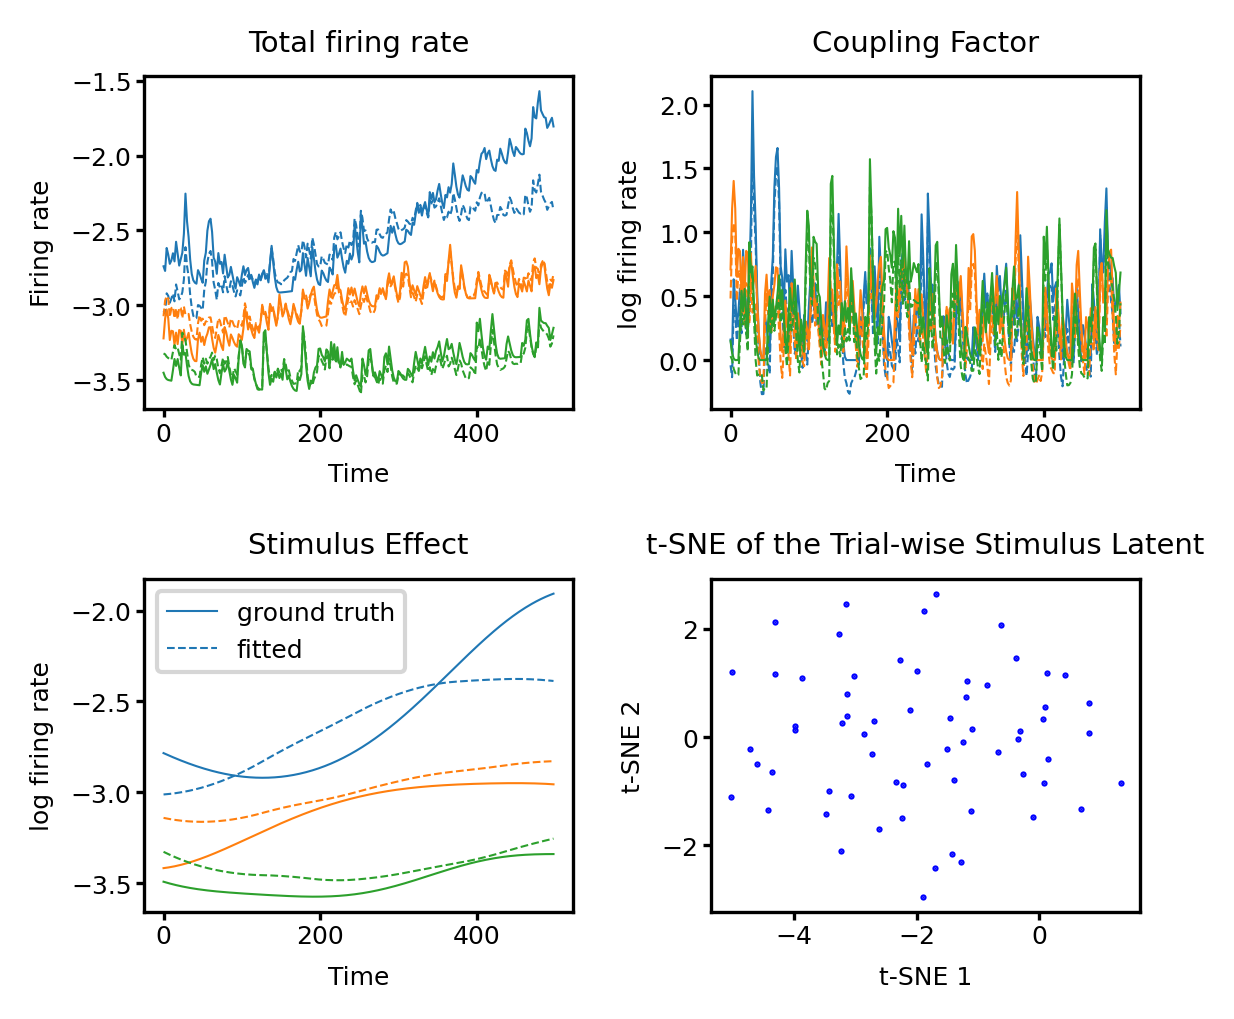

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from sklearn.manifold import TSNE

local_trial_indices = np.arange(0, 3)
neuron_idx = gt_neuron_params['nneuron_area']+2

firing_rate_test, sti_mu_test, sti_logvar_test, trial_indices, spike_train_test = trainer.predict(
    dataset='test',
    batch_indices=[0],
    include_stimulus=True,
    include_coupling=True,
    fix_stimulus=False,
    fix_latents=True,
    return_torch=True,
    return_trial_indices=True,
    return_spike_trains=True,
)

# Create a 2x2 subplot figure
utils.use_pdf_plot()
fig, axes = plt.subplots(2, 2, figsize=(4, 3.5), dpi=300)

# Plot total firing rate
xx = np.arange(firing_rate_test.shape[0]) * 2  # Adjusted x-axis
for trial_idx in local_trial_indices:
    # Plot ground truth
    axes[0, 0].plot(
        xx,
        log_firing_rate_rcd[gt_neuron_params['npadding']:, neuron_idx, trial_indices[trial_idx]],
        linestyle='-',
        color=f'C{trial_idx}',  # Match color with predicted
        label=f'ground truth',
        lw=0.5,
    )
    # Plot predicted
    axes[0, 0].plot(
        xx,
        firing_rate_test[:, neuron_idx, trial_idx].cpu().numpy(),
        linestyle='--',
        color=f'C{trial_idx}',  # Use matplotlib default color cycle
        label=f'fitted',
        lw=0.5,
    )
axes[0, 0].set_title('Total firing rate')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Firing rate')

# Plot coupling factor
for trial_idx in local_trial_indices:
    # Plot ground truth
    axes[0, 1].plot(
        xx,
        factor_coupling[gt_neuron_params['npadding']:, 0, trial_indices[trial_idx]],
        linestyle='-',
        color=f'C{trial_idx}',  # Match color with predicted
        label=f'ground truth',
        lw=0.5,
    )
    # Plot predicted
    axes[0, 1].plot(
        xx,
        trainer.model.coupling_outputs_subspace[0][1][trial_idx, 0, :].cpu().numpy(),
        linestyle='--',
        color=f'C{trial_idx}',  # Use matplotlib default color cycle
        label=f'fitted',
        lw=0.5,
    )

axes[0, 1].set_title('Coupling Factor')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('log firing rate')

# Plot stimulus effect
for trial_idx in local_trial_indices:
    # Plot ground truth
    axes[1, 0].plot(
        xx,
        baseline_mat[gt_neuron_params['npadding']:, neuron_idx, trial_indices[trial_idx]],
        linestyle='-',
        color=f'C{trial_idx}',  # Match color with predicted
        label=f'ground truth',
        lw=0.5,
    )
    # Plot predicted
    axes[1, 0].plot(
        xx,
        trainer.model.firing_rates_stimulus[trial_idx, neuron_idx, :].cpu().numpy(),
        linestyle='--',
        color=f'C{trial_idx}',  # Use matplotlib default color cycle
        label=f'fitted',
        lw=0.5,
    )
    

axes[1, 0].set_title('Stimulus Effect')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('log firing rate')
# Add legend for the first pair only
handles, labels = axes[1, 0].get_legend_handles_labels()
if len(handles) >= 2:  # Make sure we have at least one pair
    # Keep only first ground truth and fitted pair
    axes[1, 0].legend([handles[0], handles[1]], ['ground truth', 'fitted'])


# Plot t-SNE in the last subplot
sti_mu_test_np = sti_mu_test.cpu().numpy() if torch.is_tensor(sti_mu_test) else sti_mu_test

if sti_mu_test_np.shape[1] <= 2:
    print(f"Only one dimension")
elif np.all(sti_mu_test_np.std(axis=0) > 1e-3):
    tsne = TSNE(n_components=2, random_state=42)
    sti_mu_test_tsne = tsne.fit_transform(sti_mu_test_np)
    for i in range(len(sti_mu_test_tsne)):
        axes[1, 1].scatter(
            sti_mu_test_tsne[i, 0],
            sti_mu_test_tsne[i, 1],
            marker='.',
            s=1,
            color='b'
        )
    axes[1, 1].set_title('t-SNE of the Trial-wise Stimulus Latent')
    axes[1, 1].set_xlabel('t-SNE 1')
    axes[1, 1].set_ylabel('t-SNE 2')
else:
    print(
        f"Stimulus latent is not varying across trials: "
        f"{sti_mu_test_np.std(axis=0).mean()}"
    )

plt.tight_layout()
# plt.savefig('Figure/all_effects_and_tsne.pdf', bbox_inches='tight', dpi=300)


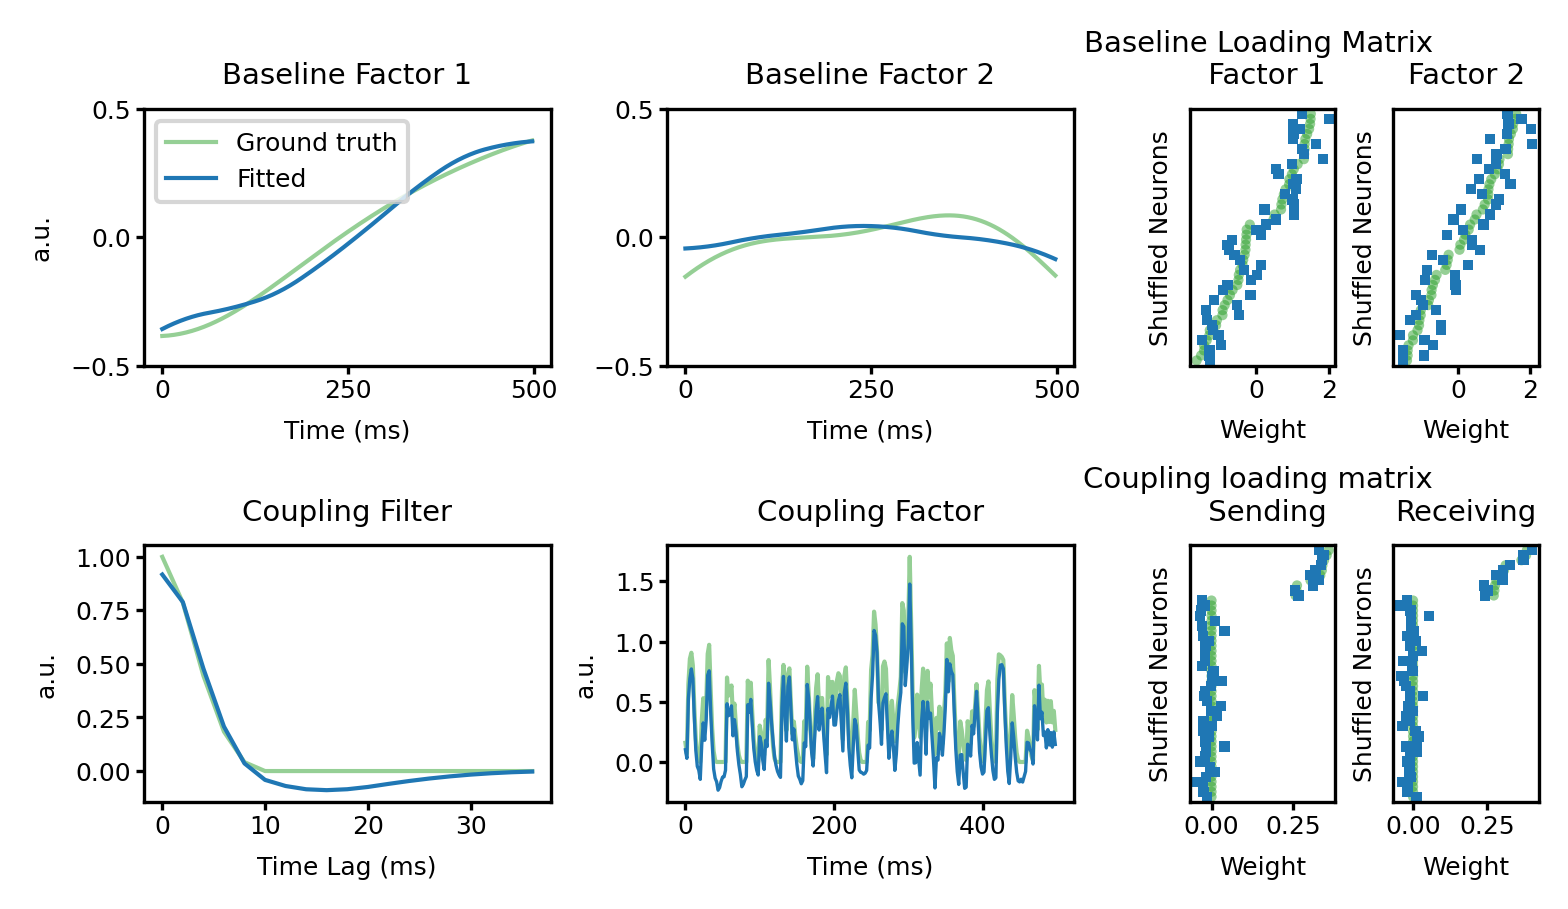

In [327]:
# Create 2x3 subplot
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

fig = plt.figure(figsize=(6, 3), dpi=300)
outer = GridSpec(2, 3, figure=fig, wspace=0.3, hspace=0.7, width_ratios=[0.35, 0.35, 0.3])
axes = np.empty((2, 3), dtype=object)
for i in range(2):
    for j in range(3):
        if (i, j) not in [(0, 2), (1, 2)]:  # we'll manually insert subpanels here
            axes[i, j] = fig.add_subplot(outer[i, j])

# Pick a trial with intermediate fit (using middle trial)
local_trial_idx = utils.find_middle_fit_trial(
    firing_rate_test, 
    spike_train_test,
)
global_trial_idx = trial_indices[local_trial_idx]
plot_area = 1
xx = np.arange(firing_rate_test.shape[0])*2

### First row - Baseline components
# Normalize both the ground truth and the fitted
readout_mat_fitted = trainer.model.sti_readout_matrix_dict["0"][plot_area].weight.detach().cpu().numpy()
readout_mat_gt = loading_mat_baseline_list[plot_area]
fitted_rescale = np.std(readout_mat_fitted, axis=0)*np.sign(readout_mat_fitted.mean(axis=0))
gt_rescale = np.std(readout_mat_gt, axis=0)*np.sign(readout_mat_gt.mean(axis=0))
npadding = gt_neuron_params['npadding']

# Baseline Factor 1
axes[0,0].plot(
    xx,
    utils.centralize_factor(
        factor_baseline_rcd[npadding:, 0, global_trial_idx, plot_area]
    *gt_rescale[0]),
    label='Ground truth', color='tab:green', alpha=0.5
)
axes[0,0].plot(
    xx,
    utils.centralize_factor(
       trainer.model.factors[local_trial_idx,plot_area,:,1].detach().cpu().numpy()
    *fitted_rescale[1]),
    label='Fitted', color='tab:blue'
)
axes[0,0].set_title('Baseline Factor 1')
axes[0,0].set_xlabel('Time (ms)')
axes[0,0].set_ylabel('a.u.')
axes[0,0].legend()
axes[0,0].set_ylim(-0.5, 0.5)
axes[0,0].set_xticks([0, 250, 500])
axes[0,0].set_yticks([-0.5, 0, 0.5])

# Baseline Factor 2
axes[0,1].plot(
    xx,
    utils.centralize_factor(
        factor_baseline_rcd[npadding:, 1, global_trial_idx, plot_area]
    *gt_rescale[1]),
    label='Ground truth', color='tab:green', alpha=0.5,
)
axes[0,1].plot(
    xx,
    utils.centralize_factor(
        trainer.model.factors[local_trial_idx,plot_area,:,0].detach().cpu().numpy()
    *fitted_rescale[0]),
    label='Fitted', color='tab:blue',
)
axes[0,1].set_title('Baseline Factor 2')
axes[0,1].set_xlabel('Time (ms)')
# axes[0,1].set_ylabel('a.u.')
# axes[0,1].legend()
axes[0,1].set_ylim(-0.5, 0.5)
axes[0,1].set_xticks([0, 250, 500])
axes[0,1].set_yticks([-0.5, 0, 0.5])


# baseline loading matrix
# Add common title for the two inner panels
inner = GridSpecFromSubplotSpec(
    1, 2, subplot_spec=outer[0, 2], hspace=0.3, wspace=0.4
)
sub_ax1 = fig.add_subplot(inner[0])
sub_ax2 = fig.add_subplot(inner[1])
utils.plot_single_factor_loading_horizontal(
    sub_ax1,
    loading_mat_baseline_list[plot_area][:,0]/gt_rescale[0],
    readout_mat_fitted[:,1]/fitted_rescale[1],
    title="Baseline Loading Matrix \n Factor 1", 
)
utils.plot_single_factor_loading_horizontal(
    sub_ax2,
    loading_mat_baseline_list[plot_area][:,1]/gt_rescale[1],
    readout_mat_fitted[:,0]/fitted_rescale[0],
    title="Factor 2", 
)


### Second row - Coupling part
# coupling filter
xxx = np.arange(basis_coupling.shape[0])*2
axes[1,0].plot(xxx,
               (basis_coupling @ connections[0]['strength'][:,0]),
               label='Ground Truth', color='tab:green', alpha=0.5,)
axes[1,0].plot(xxx,
               trainer.model.coupling_filters_dict["0"][0][1].detach().cpu().numpy(),
               label='Fitted', color='tab:blue')
axes[1,0].set_title('Coupling Filter')
axes[1,0].set_xlabel('Time Lag (ms)')
axes[1,0].set_ylabel('a.u.')
# axes[1,0].legend()


# coupling filter
axes[1,1].plot(xx,
               factor_coupling[gt_neuron_params['npadding']:, 0, global_trial_idx],
               label='Ground Truth', color='tab:green', alpha=0.5,)
axes[1,1].plot(xx,
               trainer.model.coupling_outputs_subspace[0][1][local_trial_idx, 0, :].detach().cpu().numpy(),
               label='Fitted', color='tab:blue', lw=0.8)
axes[1,1].set_title('Coupling Factor')
axes[1,1].set_xlabel('Time (ms)')
axes[0,1].set_xticks([0, 250, 500])
axes[1,1].set_ylabel('a.u.')
# axes[1,1].legend()


inner = GridSpecFromSubplotSpec(
    1, 2, subplot_spec=outer[1, 2], hspace=0.3, wspace=0.4
)
sub_ax1 = fig.add_subplot(inner[0])
sub_ax2 = fig.add_subplot(inner[1])
utils.plot_single_factor_loading_horizontal(
    sub_ax1,
    readin_mat_coupling[:gt_neuron_params['nneuron_area'], 0],
    trainer.model.cp_weight_sending_dict["0"][0][1].detach().cpu().numpy(),
    title="Coupling loading matrix \n Sending", 
)
utils.plot_single_factor_loading_horizontal(
    sub_ax2,
    loading_mat_coupling[gt_neuron_params['nneuron_area']:, 0],
    trainer.model.cp_weight_receiving_dict["0"][0][1].detach().cpu().numpy(),
    title="Receiving", 
)

# plt.savefig('Figure/Figure2_GLM_ground_truth_vs_fitted.pdf', bbox_inches='tight', dpi=300)

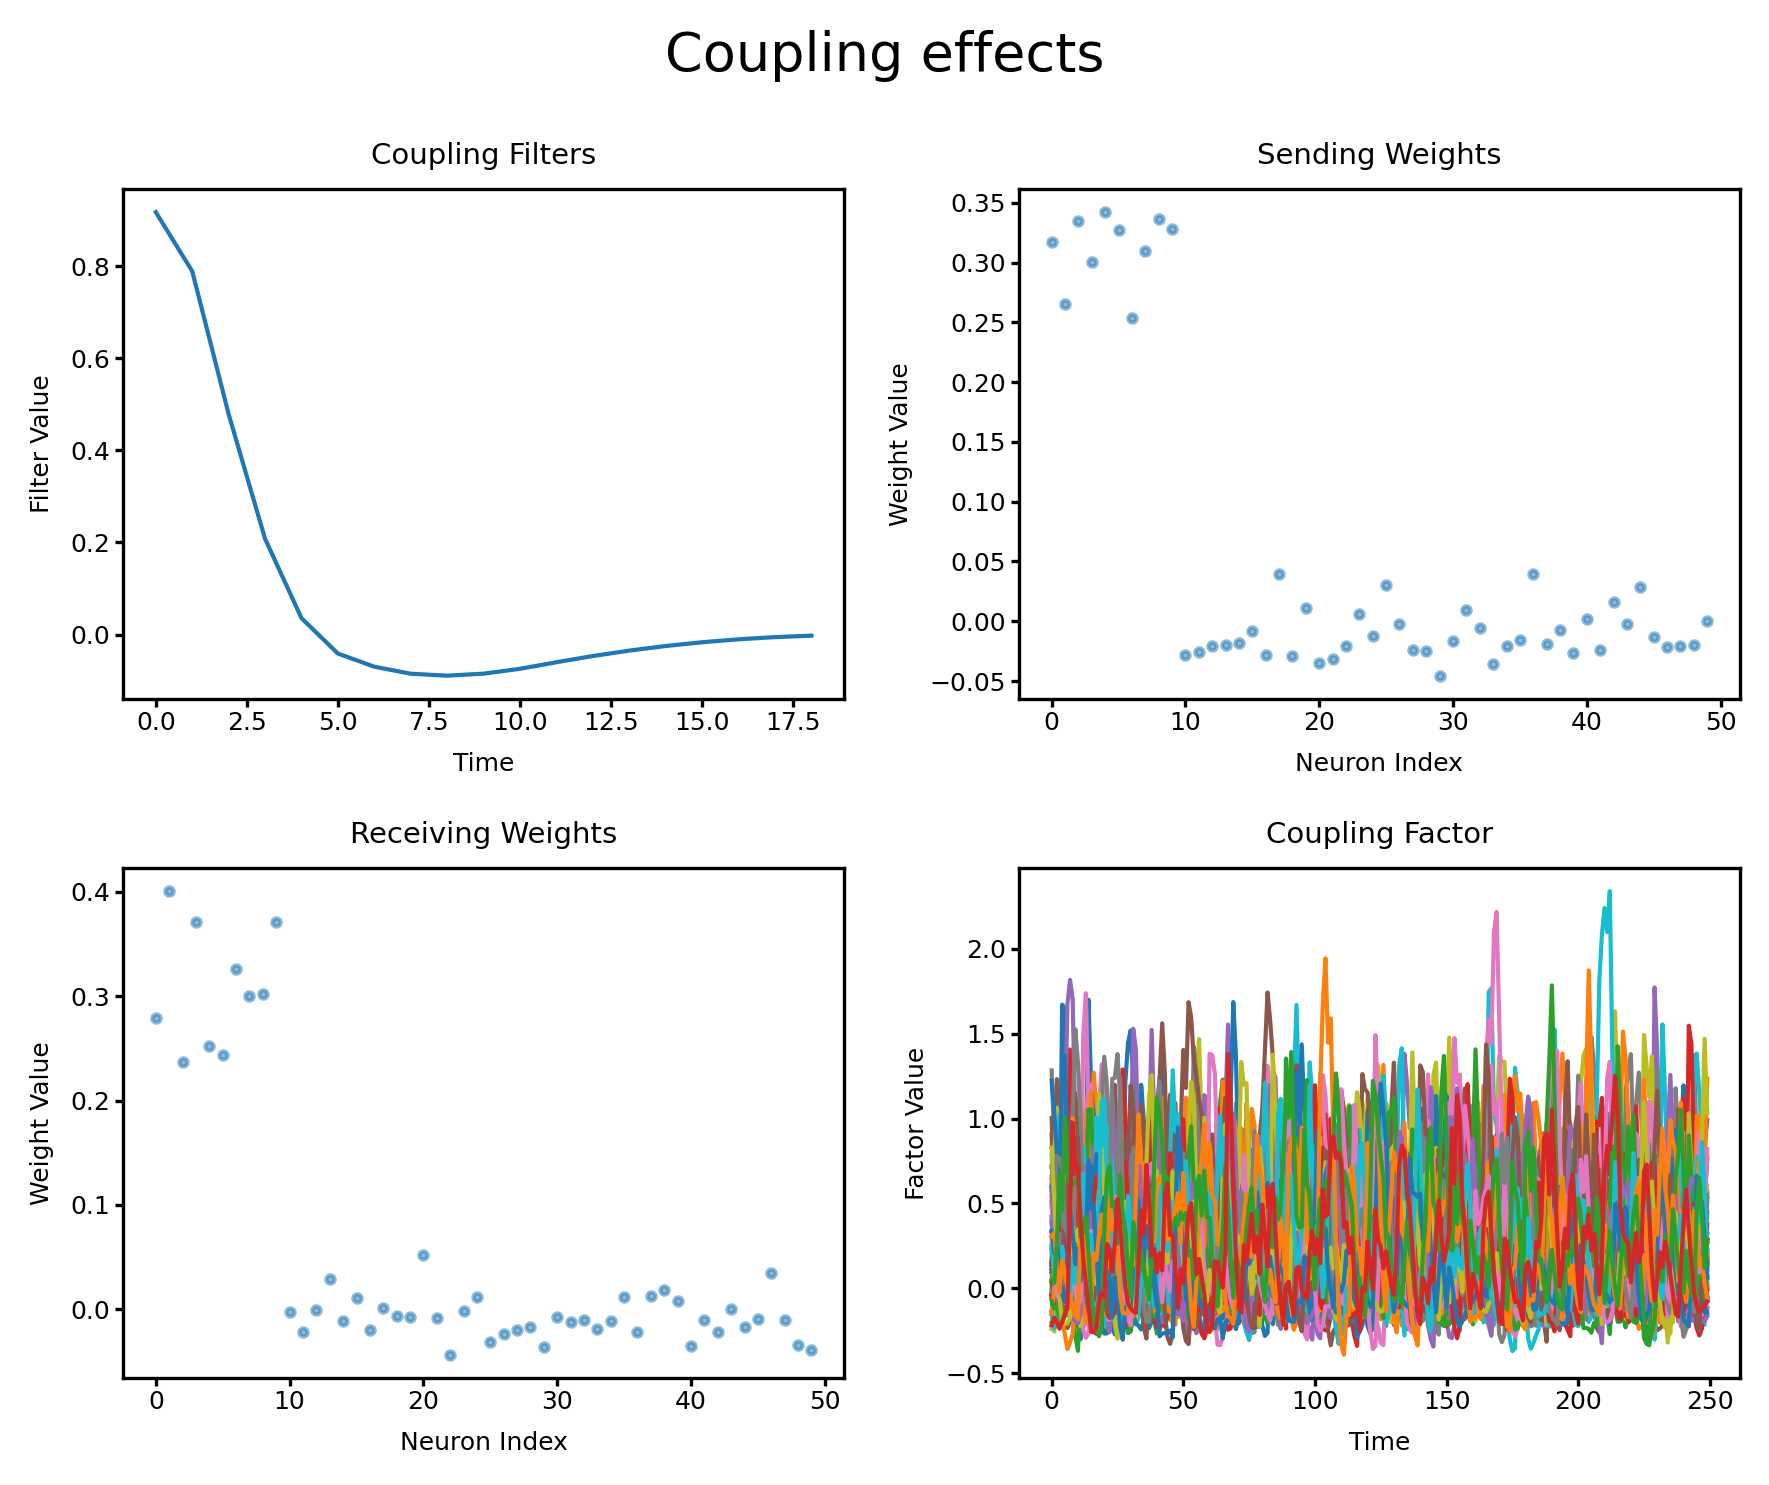

In [325]:
fig, axes = plt.subplots(2, 2, figsize=(6, 5), dpi=300)
fig.suptitle(
    'Coupling effects', 
    fontsize=13
)

# Plot coupling filters
axes[0,0].plot(trainer.model.coupling_filters_dict["0"][0][1].cpu().numpy())
axes[0,0].set_title('Coupling Filters')
axes[0,0].set_xlabel('Time')
axes[0,0].set_ylabel('Filter Value')

# Plot sending weights 
axes[0,1].plot(trainer.model.cp_weight_sending_dict["0"][0][1].detach().cpu().numpy(), 
             "o", markersize=2, alpha=0.5)
axes[0,1].set_title('Sending Weights')
axes[0,1].set_xlabel('Neuron Index')
axes[0,1].set_ylabel('Weight Value')

# Plot receiving weights
axes[1,0].plot(trainer.model.cp_weight_receiving_dict["0"][0][1].detach().cpu().numpy(), 
             "o", markersize=2, alpha=0.5)
axes[1,0].set_title('Receiving Weights')
axes[1,0].set_xlabel('Neuron Index') 
axes[1,0].set_ylabel('Weight Value')

# Plot coupling factor
axes[1,1].plot(trainer.model.coupling_outputs_subspace[0][1].detach().cpu().numpy()[:,0,:].T)
axes[1,1].set_title('Coupling Factor')
axes[1,1].set_xlabel('Time')
axes[1,1].set_ylabel('Factor Value')

plt.tight_layout()


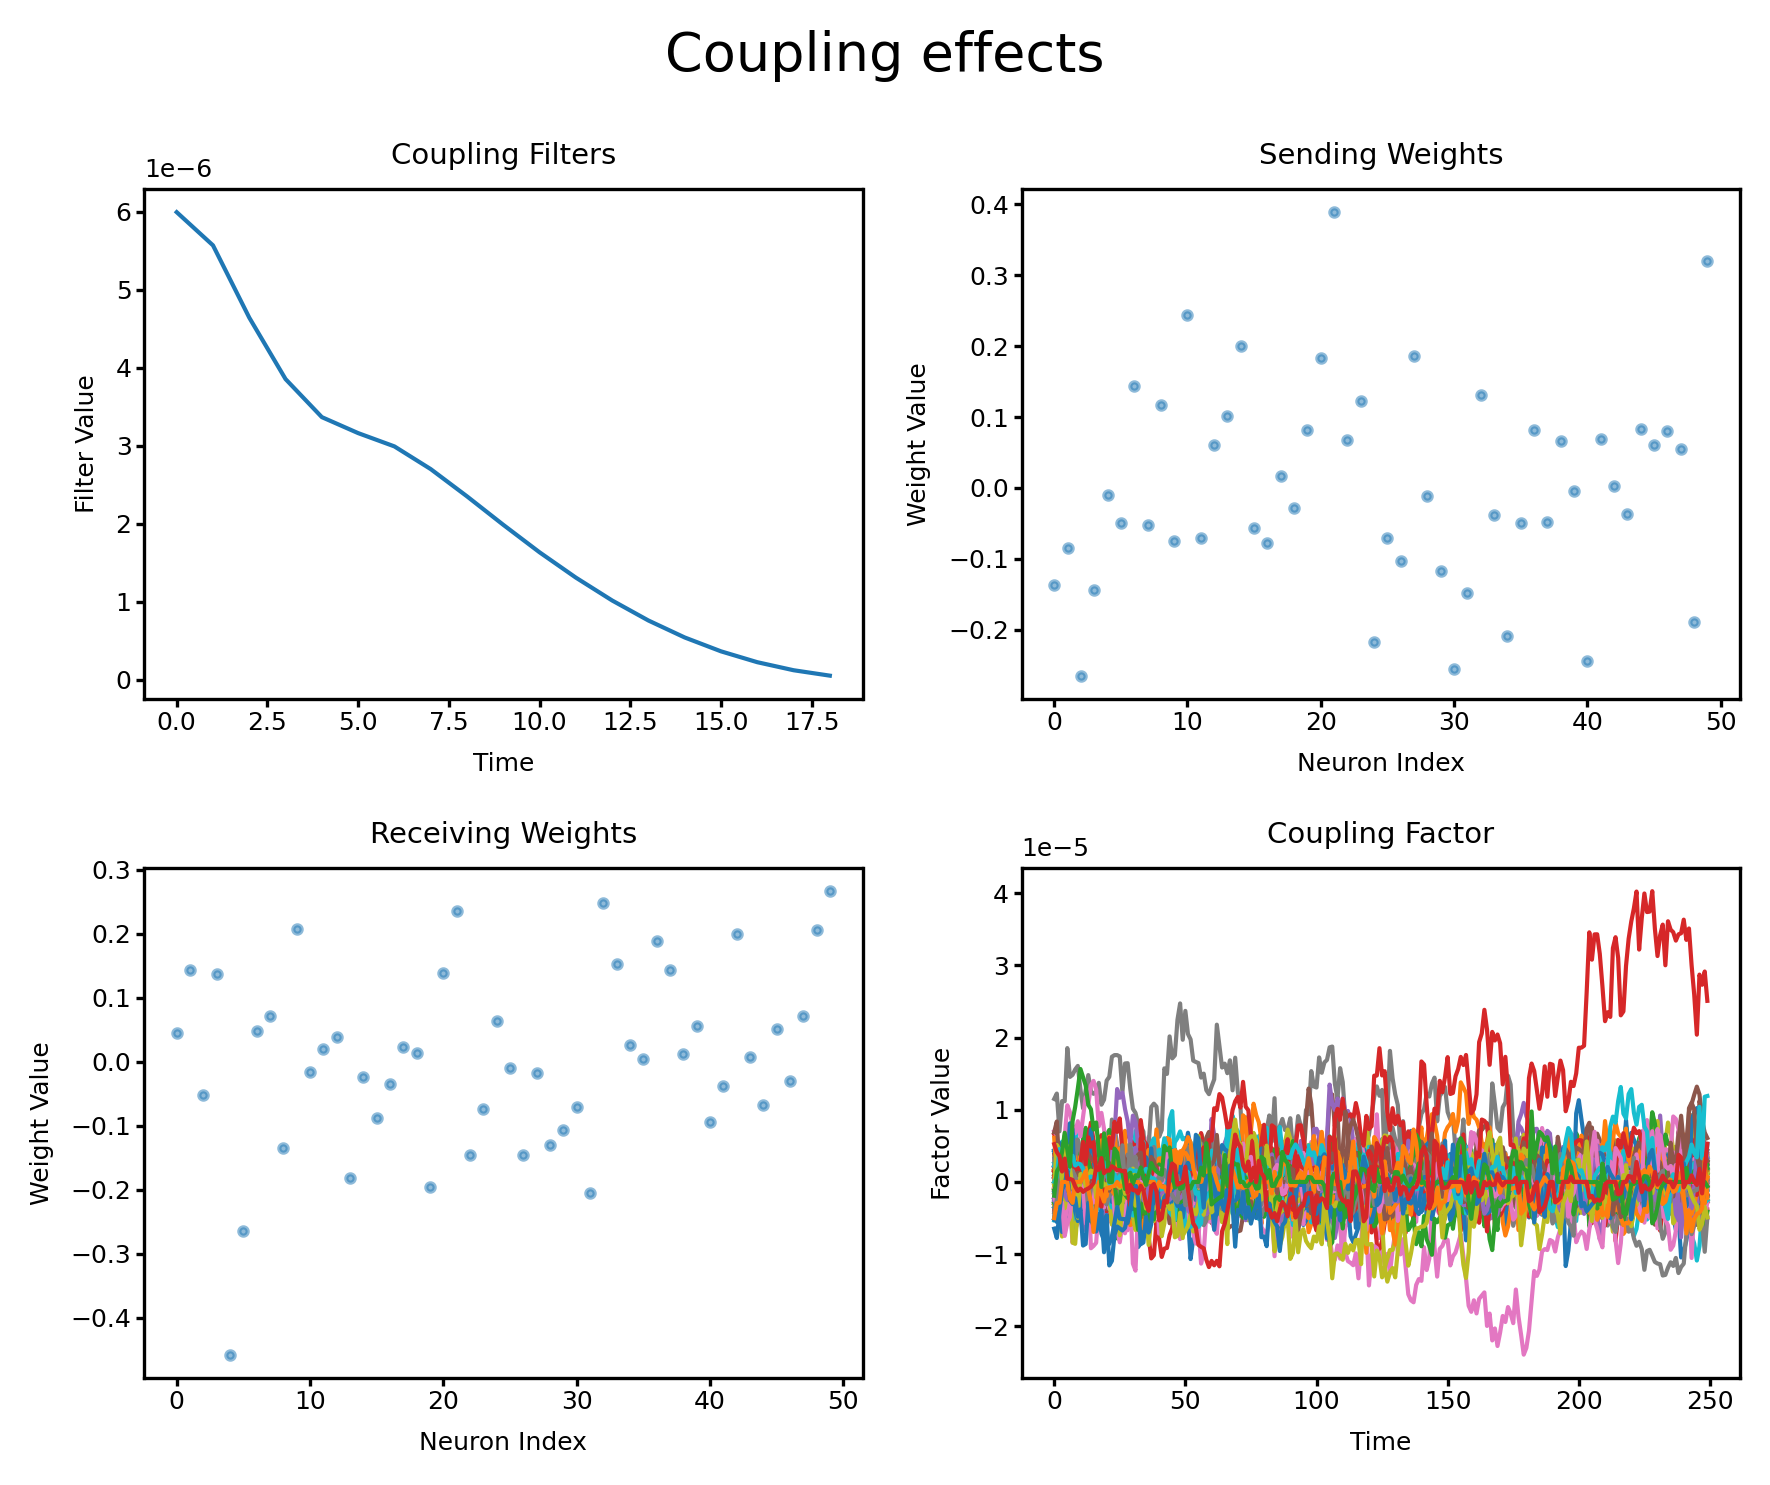

In [326]:
fig, axes = plt.subplots(2, 2, figsize=(6, 5), dpi=300)
fig.suptitle(
    'Coupling effects', 
    fontsize=13
)

# Plot coupling filters
axes[0,0].plot(trainer.model.coupling_filters_dict["0"][1][0].cpu().numpy())
axes[0,0].set_title('Coupling Filters')
axes[0,0].set_xlabel('Time')
axes[0,0].set_ylabel('Filter Value')

# Plot sending weights 
axes[0,1].plot(trainer.model.cp_weight_sending_dict["0"][1][0].detach().cpu().numpy(), 
             "o", markersize=2, alpha=0.5)
axes[0,1].set_title('Sending Weights')
axes[0,1].set_xlabel('Neuron Index')
axes[0,1].set_ylabel('Weight Value')

# Plot receiving weights
axes[1,0].plot(trainer.model.cp_weight_receiving_dict["0"][1][0].detach().cpu().numpy(), 
             "o", markersize=2, alpha=0.5)
axes[1,0].set_title('Receiving Weights')
axes[1,0].set_xlabel('Neuron Index') 
axes[1,0].set_ylabel('Weight Value')

# Plot coupling factor
axes[1,1].plot(trainer.model.coupling_outputs_subspace[1][0].detach().cpu().numpy()[:,0,:].T)
axes[1,1].set_title('Coupling Factor')
axes[1,1].set_xlabel('Time')
axes[1,1].set_ylabel('Factor Value')

plt.tight_layout()
